In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
import random
from PIL import Image,ImageDraw
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
img_path='/kaggle/input/global-wheat-detection/train/'

In [3]:
train=pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')

In [4]:
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
coords=pd.DataFrame(list(train.bbox.apply(lambda x:x[1:-1].split(',')).values),columns=['x1','y1','x2','y2'])
coords.head()

,x1,y1,x2,y2
0,834.0,222.0,56.0,36.0
1,226.0,548.0,130.0,58.0
2,377.0,504.0,74.0,160.0
3,834.0,95.0,109.0,107.0
4,26.0,144.0,124.0,117.0


In [6]:
df=pd.concat([train,coords],axis=1)
df.head()

,image_id,width,height,bbox,source,x1,y1,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [7]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['x2']=pd.to_numeric(df['x2'])
df['y2']=pd.to_numeric(df['y2'])
df['x2']=df['x1']+df['x2']
df['y2']=df['y1']+df['y2']
df.head()

,image_id,width,height,bbox,source,x1,y1,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,150.0,261.0


In [8]:
df.drop(['bbox','width','height','source'],inplace=True,axis=1)
df.head()

,image_id,x1,y1,x2,y2
0,b6ab77fd7,834.0,222.0,890.0,258.0
1,b6ab77fd7,226.0,548.0,356.0,606.0
2,b6ab77fd7,377.0,504.0,451.0,664.0
3,b6ab77fd7,834.0,95.0,943.0,202.0
4,b6ab77fd7,26.0,144.0,150.0,261.0


In [9]:
unique_imgs=df.image_id.unique()

In [10]:
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [11]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self,df,unique_imgs,indices):
        self.df=df
        self.unique_imgs=unique_imgs
        self.indices=indices
        
    def __len__(self):
        return len(self.indices) # indices is the random list of index of unique_imgs
        
    def __getitem__(self,idx):
        image_name=self.unique_imgs[self.indices[idx]]    # idx is the idx of indices, like 0,1,2... on randomized indices of imgs
        boxes=self.df[self.df.image_id==image_name].values[:,1:].astype('float')
        img=Image.open(img_path+image_name+'.jpg').convert('RGB')
        labels=torch.ones((boxes.shape[0]),dtype=torch.int64)
        target={}
        target['boxes']=torch.Tensor(boxes)
        target['label']=labels
            
        return T.ToTensor()(img),target  ## returning [image,target(boxes,label)] for train
            

In [12]:
#since getitem is based on index
train_idx,val_idx=train_test_split(range(unique_imgs.shape[0]),test_size=0.1,random_state=44)

In [13]:
def custom_collate(data):
    return data

In [18]:
train_dl=torch.utils.data.DataLoader(
                CustDat(df,unique_imgs,train_idx),
                batch_size=6,
                shuffle=True,
                collate_fn=custom_collate,
                pin_memory=True if torch.cuda.is_available() else False
            )
val_dl=torch.utils.data.DataLoader(
                CustDat(df,unique_imgs,val_idx),
                batch_size=4,
                shuffle=True,
                collate_fn=custom_collate,
                pin_memory=True if torch.cuda.is_available() else False
            )

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 238MB/s] 


In [16]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0005)
num_epochs=5

In [23]:
model.to(device)
for epochs in range(num_epochs):   # number of epochs
    print(f'-----Running epoch[{epochs}]-----')
    epoch_loss=0
    for _,data in tqdm(enumerate(train_dl),total=len(train_dl)):    #iterating over batches
        imgs=[]
        targets=[]
        for d in data:   #iterating over data in each batch
            imgs.append(d[0].to(device))
            targ={}
            targ['boxes']=d[1]['boxes'].to(device)
            targ['labels']=d[1]['label'].to(device)
            targets.append(targ)
        loss_dict=model(imgs,targets)
        loss=sum(v for v in loss_dict.values())
        epoch_loss+=loss.detach().cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epochs}] loss:',epoch_loss)

-----Running epoch[0]-----


  0%|          | 0/506 [00:00<?, ?it/s]

epoch [0] loss: 510.8546652197838
-----Running epoch[1]-----


  0%|          | 0/506 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
model.eval()
data=iter(val_dl).__next__()

In [25]:
img=data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

In [26]:
output=model([img.to(device)])

In [27]:
output

[{'boxes': tensor([[4.4539e+02, 6.9892e+01, 5.9737e+02, 1.3600e+02],
          [7.1137e+02, 1.8099e+02, 8.2782e+02, 2.4820e+02],
          [7.1577e+02, 3.0184e+02, 8.1791e+02, 3.5057e+02],
          [2.8782e+02, 1.4703e+00, 4.3180e+02, 4.8302e+01],
          [5.8518e+01, 3.1024e+02, 2.2748e+02, 3.6644e+02],
          [8.7079e+02, 9.4383e+02, 9.9949e+02, 9.8564e+02],
          [9.4305e+02, 1.7070e+02, 1.0232e+03, 2.5001e+02],
          [7.6380e+02, 1.5375e+02, 8.9193e+02, 1.9740e+02],
          [7.0300e+02, 2.1724e-01, 8.2466e+02, 4.6339e+01],
          [4.0220e-01, 5.9261e+02, 1.0263e+02, 6.5310e+02],
          [3.0838e+02, 9.2861e+02, 4.9170e+02, 9.9940e+02],
          [2.8908e+02, 3.4517e+02, 4.3124e+02, 3.9755e+02],
          [6.8342e+02, 7.2657e+02, 8.1493e+02, 7.8632e+02],
          [9.2251e+01, 8.2580e+02, 2.6497e+02, 8.7103e+02],
          [8.2392e+02, 2.4401e+02, 9.5142e+02, 3.0885e+02],
          [4.4047e+00, 1.6660e+01, 1.5732e+02, 8.7327e+01],
          [4.4822e+00, 9.6740e+

In [28]:
out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

In [30]:
keep=torchvision.ops.nms(out_bbox,out_scores,0.35)

In [31]:
im=(img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

In [32]:
vsample=Image.fromarray(im)

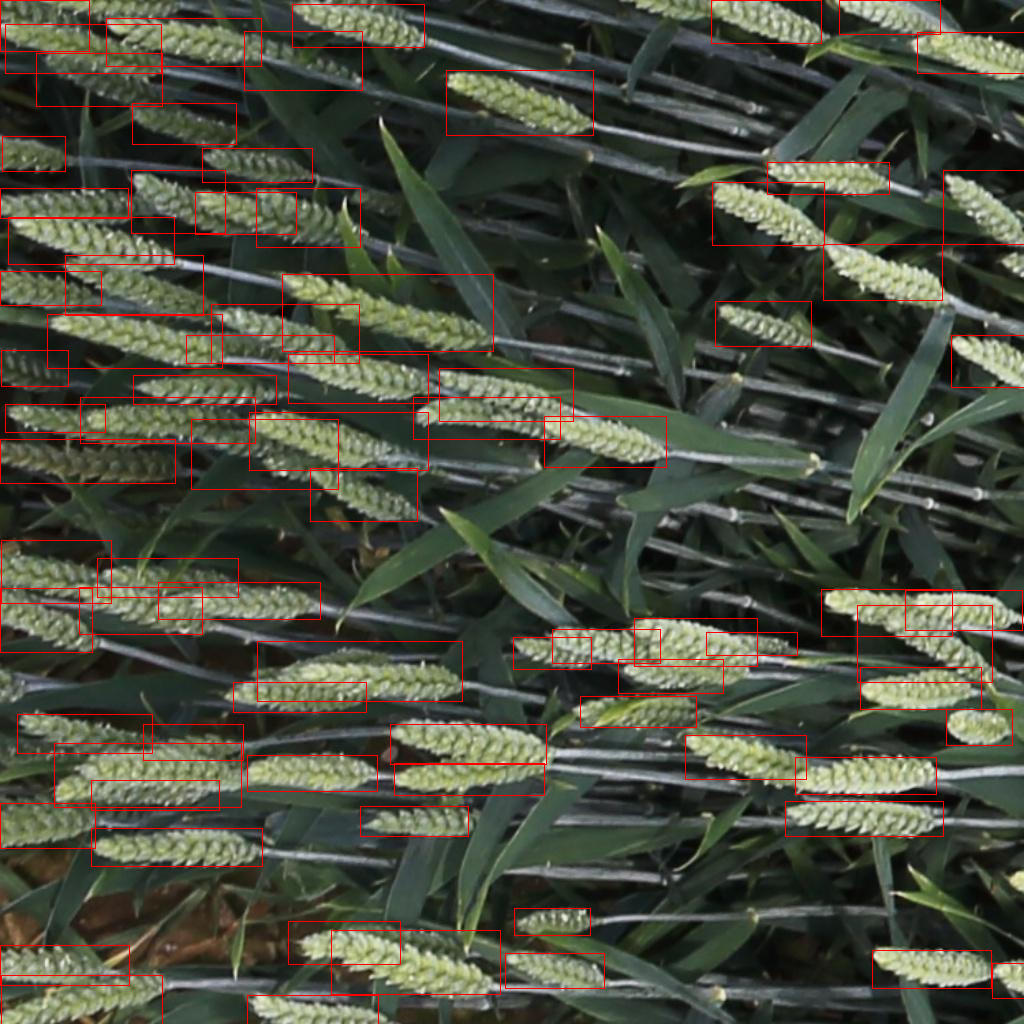

In [34]:
draw=ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box),fill=None,outline='red')
vsample